In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 07b

## Neural Network with
- One hidden layers 
- ${tanh}$ activation function
- Multi-class output
- FIFA dataset
- Normal Distribution

<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
# Lets import some libraries
import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

%matplotlib inline

In [36]:
# Some basic parameters
inpDir = '../input'
outDir = '../output'
modelDir = '../models'
subDir = 'fifa_2019'
RANDOM_STATE = 24
SAVE_MODEL = False
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 30001 # number of epochs
ALPHA = 0.1 # learning rate
NUM_SAMPLES = 1280 # How many samples we want to generate 
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'brg' # plt.cm.Spectral

plt.rcParams.update(params)

In [4]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))

## Helper Function to Plot Loss and accuracy

In [5]:
def plot_hist(hist_df):
    
    fig, axes = plt.subplots(1,2 , figsize = (15,6),)

    l_range = 5 # ignoring first few records
    x_var = hist_df.columns[0] # first colum is epoch
    y1_var = hist_df.columns[1] # Train loss
    y2_var = hist_df.columns[2] # Test loss

    ax = axes[0]

    loss_df[l_range:].plot(x = x_var, y = [y1_var, y2_var], ax = ax)

    # get values for plotting
    st_loss = hist_df[y1_var].iloc[0]
    end_loss = hist_df[y1_var].iloc[-1]
    t_st_loss = hist_df[y2_var].iloc[0]
    t_end_loss = hist_df[y2_var].iloc[-1]

    # little beautification
    train_txtstr = "Train Loss: \n  Start : {:7.4f}\n    End : {:7.4f}".format( st_loss, end_loss )    # Train text to plot

    test_txtstr = "Test Loss: \n  Start : {:7.4f}\n    End : {:7.4f}".format( t_st_loss, t_end_loss ) # Test text to plot
    txtstr = ' {} \n{}'.format(train_txtstr, test_txtstr)
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    ax.set_xlabel(x_var)
    ax.set_ylabel(y1_var)
    ax.set_title('Overall')
    ax.grid();

    ax = axes[1]

    y1_var = hist_df.columns[3] # Train Accuracy
    y2_var = hist_df.columns[4] # Test Accuracy

    loss_df[l_range:].plot(x = x_var, y = [y1_var, y2_var], ax = ax)

    # get values for plotting
    st_loss = hist_df[y1_var].iloc[0]
    end_loss = hist_df[y1_var].iloc[-1]
    t_st_loss = hist_df[y2_var].iloc[0]
    t_end_loss = hist_df[y2_var].iloc[-1]

    # little beautification
    train_txtstr = "Train Accuracy: \n  Start : {:7.4f}\n    End : {:7.4f}".format( st_loss, end_loss )    # Train text to plot

    test_txtstr = "Test Accuracy: \n  Start : {:7.4f}\n    End : {:7.4f}".format( t_st_loss, t_end_loss ) # Test text to plot# properties  matplotlib.patch.Patch 
    txtstr = ' {} \n{}'.format(train_txtstr, test_txtstr)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    ax.set_xlabel(x_var)
    ax.set_ylabel(y1_var)
    ax.set_title('Accuracies'.format(l_range))
    ax.grid();
    plt.tight_layout()

## Read FIFA 2019 data set

In [6]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [7]:
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [8]:
cols = data_df.columns

for col in cols:
    print('\nColumn Name ', col, ':', data_df[col].unique())


Column Name  Unnamed: 0 : [    0     1     2 ... 18204 18205 18206]

Column Name  ID : [158023  20801 190871 ... 241638 246268 246269]

Column Name  Name : ['L. Messi' 'Cristiano Ronaldo' 'Neymar Jr' ... 'B. Worman'
 'D. Walker-Rice' 'G. Nugent']

Column Name  Age : [31 33 26 27 32 25 29 28 24 30 19 40 22 23 34 35 36 37 21 18 20 39 41 17
 38 45 42 16 44]

Column Name  Photo : ['https://cdn.sofifa.org/players/4/19/158023.png'
 'https://cdn.sofifa.org/players/4/19/20801.png'
 'https://cdn.sofifa.org/players/4/19/190871.png' ...
 'https://cdn.sofifa.org/players/4/19/241638.png'
 'https://cdn.sofifa.org/players/4/19/246268.png'
 'https://cdn.sofifa.org/players/4/19/246269.png']

Column Name  Nationality : ['Argentina' 'Portugal' 'Brazil' 'Spain' 'Belgium' 'Croatia' 'Uruguay'
 'Slovenia' 'Poland' 'Germany' 'France' 'England' 'Italy' 'Egypt'
 'Colombia' 'Denmark' 'Gabon' 'Wales' 'Senegal' 'Costa Rica' 'Slovakia'
 'Netherlands' 'Bosnia Herzegovina' 'Morocco' 'Serbia' 'Algeria' 'Austria'
 'Gr

In [9]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [10]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [11]:
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [12]:
# Are there NaNs Still?

data_df.isna().sum()

Position           0
Finishing          0
HeadingAccuracy    0
ShortPassing       0
Volleys            0
Dribbling          0
Curve              0
FKAccuracy         0
LongPassing        0
BallControl        0
Acceleration       0
SprintSpeed        0
Agility            0
Reactions          0
Balance            0
ShotPower          0
Jumping            0
Stamina            0
Strength           0
LongShots          0
Aggression         0
Interceptions      0
Positioning        0
Vision             0
Penalties          0
Composure          0
Marking            0
StandingTackle     0
SlidingTackle      0
GKDiving           0
GKHandling         0
GKKicking          0
GKPositioning      0
GKReflexes         0
dtype: int64

In [13]:
# limiting 'Targets' to 4 values
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [14]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Mid-fielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Helps in preventing pandas from complaining
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [15]:
labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [16]:
y = data_df["Position"].values

X = data_df.drop("Position", axis = 1)

In [17]:
# one hot encoding
y = pd.get_dummies(y).values
y

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0]], dtype=uint8)

In [18]:
#  Split the data in training and test sets to measure performance of the model

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14517, 33) (14517, 4) (3630, 33) (3630, 4)


In [19]:
# check type of X_train
type(X_train)

pandas.core.frame.DataFrame

In [20]:
# Fit_transform scaler on train set aand transform on test set

sc = StandardScaler()

X_train = sc.fit_transform(X_train) # Fit transform on train

X_test = sc.transform(X_test) # transform on test

In [21]:
type(X_train), type (y_test)

(numpy.ndarray, numpy.ndarray)

# Prepare model

- Train and calculate accuracies
- Discuss your observations

In [22]:
# Activation function for output layer

def fn_softmax(z: np.ndarray):
    
    '''
    Args:
        z : np.ndarray, shape (m, n_output)
    returns:
        probabilities of each class
    
    '''
    
    exp_sc = np.exp(z)
    
    return exp_sc / np.sum( exp_sc , axis =1, keepdims=True)
    

In [23]:
def fn_activ(z: np.ndarray):
    
    '''
        Args:
           z : array, Aggregated values 
       Return:
           Activations for each z
    '''

    return np.tanh(z)

def fn_activ_prime(z: np.ndarray):
    '''
        Args:
           z : array, Aggregated values 
       Return:
           Derivative, for each z
    '''

    return 1.0 - np.tanh(z)**2

In [24]:
def calculate_loss(model, X_l: np.ndarray, y_l: np.ndarray):
    '''
    Args:
        model: dictionay object containing weights and biases
        X_l: Feature Matrix to calculate loss
        y_y: Labels array to calculate loss
    Returns:
        Average loss
    '''
    
    # extract weights and losses from the model
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    m = X_l.shape[0] # --------------------------------- size of matrix X(current)
    
    # Forward propagation to calculate our predictions
    # Layer 1
    z1 = X_l.dot(W1) + b1
    
    # Activation
    a1 = fn_activ(z1)
    
    # Layer 2
    z2 = a1.dot(W2) + b2
    
    # Activation
    a2 = fn_softmax(z2)
    
    # Calculating the loss
    data_loss = -(y_l * np.log(a2) + (1 - y_l) * np.log(1 - a2)).sum()  

    return 1./m * data_loss

In [25]:
# Helper function to predict an output (0 or 1)

def predict(model, X_p: np.ndarray):
    '''
     Args:
         model
         X_p: Feature Matrix to predict
    Returns:
        Predictions against the instances
         
    '''
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation
    z1 = X_p.dot(W1) + b1
    
    a1 = fn_activ(z1)
    
    z2 = a1.dot(W2) + b2
    
    a2 = fn_softmax(z2)# Softmax
    
    return np.argmax(a2, axis = 1) # pick with one with highest probabilities

In [26]:
# prepare the Model

def build_model(nn_hdim, 
                X : np.ndarray, y : np.ndarray,
                X_t: np.ndarray, y_t: np.ndarray,
                alpha = 0.1,
                epochs = 20000, 
                print_loss=False):
    
    '''
    Args:
        nn_hdim : Number of nodes in the hidden layer
        X :   Train features
        y :   Train targets (labels)
        X_t : Test features
        y_t : Test targets (labels)
        epochs : Number of passes through the train data for gradient descent
        alpha : learning rate
        print_loss : If True, print the loss every nnn iterations
        
    Returns:
        Model: Dictionary object containing weights and biases
    '''
    
    # Initialize the parameters to random values. We need to learn these.
    # Weights
    
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    # Bias
    b1 = np.zeros((1, nn_hdim))
    b2 = np.zeros((1, nn_output_dim))

    
    curr_loss = 0
    epoch, loss, t_loss, acc, t_acc= [], [], [], [], []  # Bunch of lists to accumulate loss and accuracy
    
    num_examples = X.shape[0] # How many training examples
    
    # Gradient descent. For each batch...
    for i in range(0, epochs):
        
        ##########################
        #   Forward propagation  #
        ##########################
        
        # Layer 1
        z1 = X.dot(W1) + b1 # Aggregation function
        a1 = fn_activ(z1)  # Activation function
        
        # Layer 2
        z2 = a1.dot(W2) + b2 # Aggregation function
        a2 = fn_softmax(z2) # Activation function

        #######################
        #   Back propagation  #
        #######################
        
        # Layer 2
        dz2 = a2 - y # its mandatory to keep y dim same as a2 and type as np.ndarray

        dW2 = (a1.T).dot(dz2)
        assert(W2.shape == dW2.shape), 'Shape of W2 {} and dW2 {} do not match'.format(W2.shape, dW2.shape)
        
        db2 = np.sum(dz2, axis=0, keepdims=True) # db2 is sum along axis 0
        assert(b2.shape == db2.shape), 'Shape of b2 {} and db2 {} do not match'.format(b2.shape, db2.shape)
            
        dz1 = dz2.dot(W2.T) * fn_activ_prime(z1)  #derivative of tanh
        #                                        '*' indicates element wise multiplication
        assert(z1.shape == dz1.shape), 'Shape of z1 {} and dz1 {} do not match'.format(W2.shape, dW2.shape)
        
        dW1 = np.dot(X.T, dz1)
        assert(W1.shape == dW1.shape), 'Shape of W1 {} and dW1 {} do not match'.format(W1.shape, dW1.shape)
        
        db1 = np.sum(dz1, axis=0, keepdims=True) 
        assert(b1.shape == db1.shape), 'Shape of b1 {} and db1 {} do not match'.format(b1.shape, db1.shape)
        
        # Gradient descent parameter update
        W1 += -alpha * dW1/num_examples
        b1 += -alpha * db1/num_examples
        W2 += -alpha * dW2/num_examples
        b2 += -alpha * db2/num_examples
        
        # Model as a Dict object to be return
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        curr_loss = calculate_loss(model, X, y)
        loss.append(curr_loss)
        #_________________________________________
        tcurr_loss = calculate_loss(model, X_t, y_t)
        t_loss.append(tcurr_loss)

        # calculate accuracy
        y_pred = predict(model, X)
        curr_acc = accuracy_score(np.argmax(y, axis = 1), y_pred) 
        acc.append(curr_acc)

        yt_pred = predict(model, X_t)
        tcurr_acc = accuracy_score(np.argmax(y_t, axis = 1), yt_pred) 
        t_acc.append(tcurr_acc)
        #-----------------------------

        epoch.append(i)
        
        # Print the loss.
        if print_loss and i % 1000 == 0:
            print('\nEpoch {0:06d}'.format(i))
            print(' - Loss     {1:6.4f} | {1:6.4f}'.format(curr_loss, tcurr_loss))
            print(' - Accuracy {1:6.4f} | {1:6.4f}'.format(curr_acc, tcurr_acc))
            print('-'*30)
    
    loss_hist['epoch'] = epoch
    loss_hist['loss'] = loss
    loss_hist['test_loss'] = t_loss
    loss_hist['acc'] = acc
    loss_hist['test_acc'] = t_acc
    
    return model

In [27]:
X_train.shape, y_train.shape , (X_train.shape[1] + y_train.shape[1])// 2

((14517, 33), (14517, 4), 18)

In [28]:
# num_examples = len(X_train)        # training set size
nn_input_dim = X_train.shape[1]    # input layer dimensionality
nn_output_dim = y_train.shape[1]   # output layer dimensionality

nn_hidden_dim = (X_train.shape[1] + y_train.shape[1])// 2 # make sure its an integer

# lists to facilitate plotting 
loss_hist = {}

In [30]:
# lets save trained model in a pickle file
modelFilePath = os.path.join(modelDir,subDir, 'S07_fifa_1L_model.pkl')

In [31]:
# Build a model with a one hidden layer
model = build_model(nn_hidden_dim, 
                    X_train, y_train, 
                    X_test, y_test,
                    epochs = EPOCHS, 
                    alpha = ALPHA, 
                    print_loss=True)


Epoch 000000
 - Loss     1.9014 | 1.9014
 - Accuracy 0.5328 | 0.5328
------------------------------

Epoch 001000
 - Loss     0.5711 | 0.5711
 - Accuracy 0.8780 | 0.8780
------------------------------

Epoch 002000
 - Loss     0.5572 | 0.5572
 - Accuracy 0.8821 | 0.8821
------------------------------

Epoch 003000
 - Loss     0.5509 | 0.5509
 - Accuracy 0.8851 | 0.8851
------------------------------

Epoch 004000
 - Loss     0.5475 | 0.5475
 - Accuracy 0.8857 | 0.8857
------------------------------

Epoch 005000
 - Loss     0.5457 | 0.5457
 - Accuracy 0.8862 | 0.8862
------------------------------

Epoch 006000
 - Loss     0.5450 | 0.5450
 - Accuracy 0.8857 | 0.8857
------------------------------

Epoch 007000
 - Loss     0.5450 | 0.5450
 - Accuracy 0.8873 | 0.8873
------------------------------

Epoch 008000
 - Loss     0.5455 | 0.5455
 - Accuracy 0.8862 | 0.8862
------------------------------

Epoch 009000
 - Loss     0.5463 | 0.5463
 - Accuracy 0.8854 | 0.8854
---------------------

In [32]:
loss_df = pd.DataFrame(loss_hist) # Loss Dataframe for plotting losses
loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,1.910307,1.901416,0.537301,0.532782
1,100,0.732793,0.720440,0.847420,0.846556
2,200,0.656893,0.643672,0.862230,0.861708
3,300,0.628141,0.614918,0.867948,0.869421
4,400,0.613550,0.600230,0.870841,0.871625


In [33]:
print ('Model:\n', model.keys())

Model:
 dict_keys(['W1', 'b1', 'W2', 'b2'])


In [37]:
# Save model and Loss dataframe 

model_details = {}

model_details['description'] = f'''Hidden layers : 1;
Layer sizes: 
    Input-{nn_input_dim}; Hidden-{nn_hidden_dim},Output-{nn_output_dim}'''

model_details['weights'] = model

if SAVE_MODEL:
    
    with open(modelFilePath, 'wb') as file:
        pickle.dump(model_details, file, protocol=pickle.HIGHEST_PROTOCOL)
        
    loss_df.to_csv(os.path.join(modelDir, subDir, 'S07_fifa_1L_normal_model_loss.csv'))

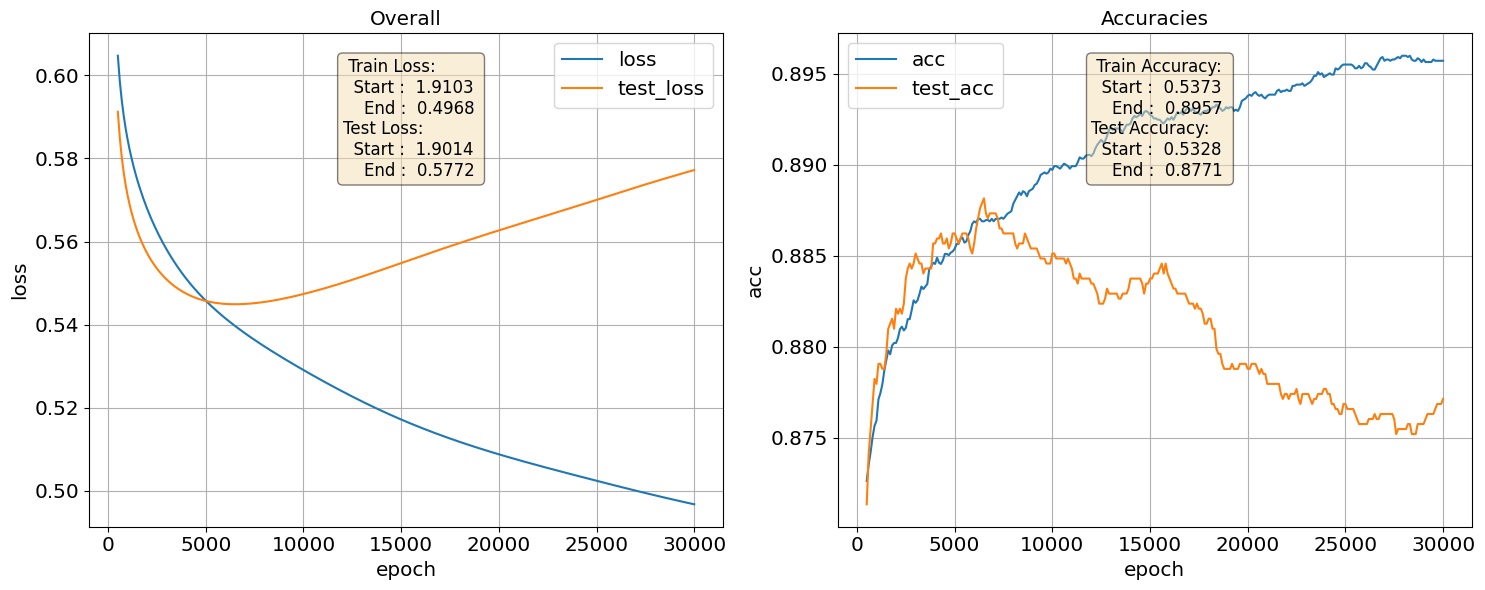

In [38]:
plot_hist(loss_df)

### How well did we perform on training data

In [39]:
y_pred = predict(model, X_train)
print('Accuracy score on Train Data :{:.5f}'.format( accuracy_score(np.argmax(y_train, axis = 1), y_pred ) ) )

Accuracy score on Train Data :0.89571


In [40]:
print(classification_report(np.argmax(y_train, axis = 1), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.93      0.94      0.93      4693
           2       0.85      0.88      0.87      5470
           3       0.87      0.80      0.83      2734

    accuracy                           0.90     14517
   macro avg       0.91      0.90      0.91     14517
weighted avg       0.90      0.90      0.90     14517



In [41]:
cm  = confusion_matrix(np.argmax(y_train, axis = 1), y_pred)

disp_train = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels.values())

print (cm)

[[1620    0    0    0]
 [   0 4389  303    1]
 [   0  322 4810  338]
 [   0   12  538 2184]]


### How about test data

In [42]:
y_pred = predict(model, X_test)

print('Accuracy score on Test Data :{:.5f}'.format(accuracy_score(np.argmax(y_test, axis = 1), y_pred)))

Accuracy score on Test Data :0.87713


In [43]:
print(classification_report(np.argmax(y_test, axis = 1), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       0.92      0.92      0.92      1173
           2       0.82      0.86      0.84      1368
           3       0.84      0.76      0.80       684

    accuracy                           0.88      3630
   macro avg       0.90      0.89      0.89      3630
weighted avg       0.88      0.88      0.88      3630



In [44]:
cm  = confusion_matrix(np.argmax(y_test, axis = 1), y_pred)

disp_test = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels.values())

print (cm)

[[ 405    0    0    0]
 [   0 1082   91    0]
 [   0   95 1177   96]
 [   0    2  162  520]]


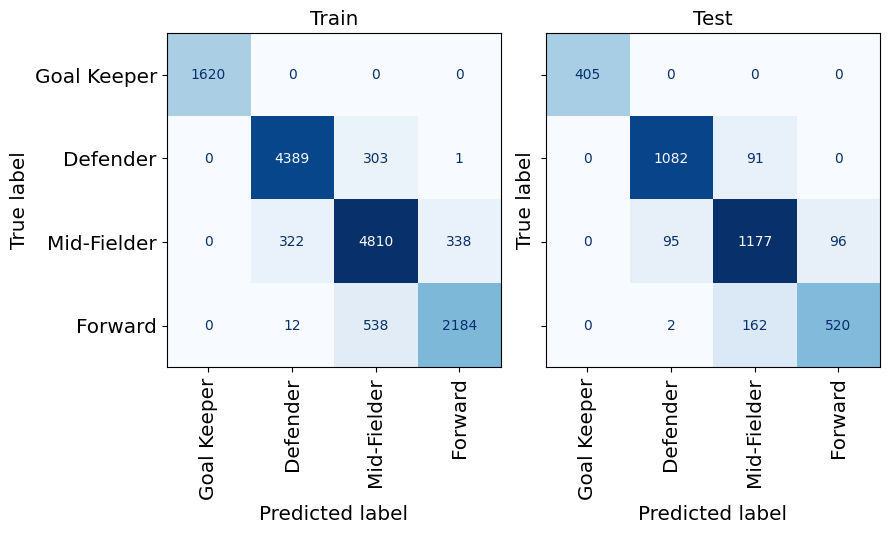

In [45]:
fig, axes = plt.subplots(1, 2, figsize = (9,15), sharey=True)

disp_train.plot(ax = axes[0], cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
axes[0].set_title('Train')
disp_test.plot(ax = axes[1], cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
axes[1].set_title('Test')
plt.tight_layout()
plt.show();

In [46]:
loss_df[loss_df['test_loss'] == loss_df['test_loss'].min()]

,epoch,loss,test_loss,acc,test_acc
65,6500,0.53969,0.544919,0.886891,0.888154


<div class="alert alert-block alert-warning" style="font-family: Arial; font-size:1.1em;">
    <h2>Note on Normal Distribution!</h2>

- **For Uniform distribution**, we could have achieved Training and Testing accuracies very close to each other, **0.888751 and	0.888705**, respectively by epoch 9200 .
- It became **0.886891	and 0.888154** for Normal distribution.
- However, accuracy reached a peak only once. In uniform distribution it was close to 0.8887 for some time before it started showing signs of over tuning.

- But by training for higher number of epochs, our testing accuracy dropped to **0.87713** lower than the test accuracy.
<div>